In [38]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
BASE_PATH = './..'
sys.path.append(BASE_PATH)

from dynaphos import utils
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy
from dynaphos import cortex_models

import torch

from matplotlib_scalebar.scalebar import ScaleBar

In [32]:
# Load colorstyles 
# plt.style.use('../_figurestyle/small.mplstyle')
# COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')

# LINE_COLOR = COLORSTYLE['red'][1]
# BOUNDS_COLOR = COLORSTYLE['turquoise'][2]

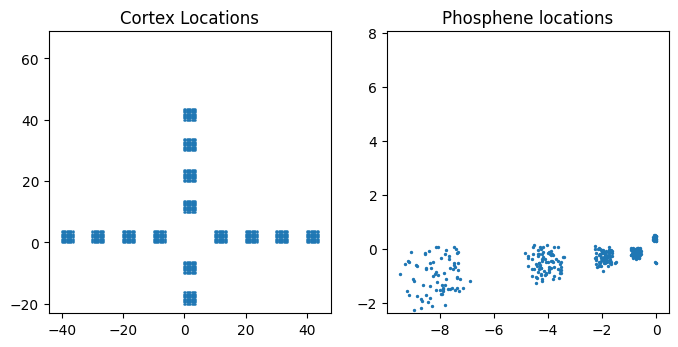

In [185]:
PLOT_TRUE_CORTEX_LOCATIONS = False # set true for plotting the distorted cortex locations corresponding to the phosphenes. 


# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))

# initialise phopshene locations, either using a cortex model or semi-probabilistically
x,y = utils.load_coordinates_from_yaml(os.path.join(BASE_PATH, 'electrode_schemes', 'squares_test.yaml'))
coordinates_cortex = Map(x,y)
coordinates_visual_field = get_visual_field_coordinates_from_cortex(params['cortex_model'], coordinates_cortex)

if PLOT_TRUE_CORTEX_LOCATIONS:
    # plot electrode locations (convert back from phosphene locataions to capture the added dropout and noise)
    visual_field_to_cortex = cortex_models.get_mapping_from_visual_field_to_cortex(params['cortex_model'])
    z = coordinates_visual_field.flip(hor=True, vert=True).complex
    coordinates_cortex = Map(z=visual_field_to_cortex(z))

    
# Plot cortex locations
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].scatter(*coordinates_cortex.cartesian, marker= '.', s=2)
axs[0].axis('square')
axs[0].set_title('Cortex Locations')


# plot phosphene locations
r, phi = coordinates_visual_field.polar
axs[1].scatter(r*np.cos(phi),r*np.sin(phi), s=2)
axs[1].axis('square')
axs[1].set_title('Phosphene locations')
plt.show()

# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

In [167]:
# save coordinates_visual_field to pickle
import pickle
path = '../electrode_schemes/1utaharray.pickle'
with open(path, 'wb') as f:
    pickle.dump(coordinates_visual_field, f)
print(f'Saved coordinates_visual_field to {path}')


Saved coordinates_visual_field to ../electrode_schemes/1utaharray.pickle


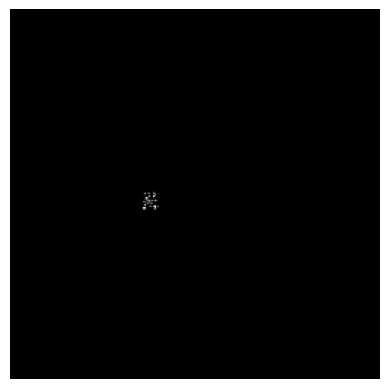

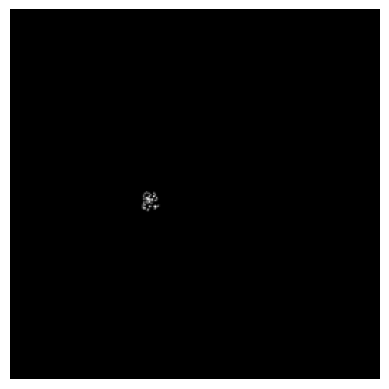

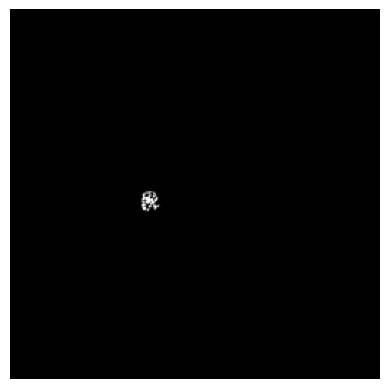

In [168]:
# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

# plot phosphenes for different input strengths
stims = np.array([60.,80.,100.])*1e-6

imgs = []
for i,stim in enumerate(stims):

    simulator.reset()
    stim_pattern = stim*torch.ones(N_PHOSPHENES,device=device)
    img = to_numpy(simulator(stim_pattern)).clip(max=1)[0]
    imgs.append(img)

    plt.imshow(img, cmap='gray', origin='lower')
    plt.axis('off')
    plt.show()